# Collaborative Filtering using Matrix Factorization

![CF](imgs/netflixCF.png)

## Intro
The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
moviesDF=pd.read_csv("ml-1m/movies.dat",sep='::',engine="python",header=None)
moviesDF.columns=["movieId","title","genres"]

### Data Preprocessing

drop unused columns and set internal movies and users unique sequential identifiers

In [3]:
def prepareDataset(myMovies):
    print("======= Preparing Dataset =======")
    ratings = pd.read_csv('ml-1m/ratings.dat',sep='::',engine="python",header=None)
    ratings.columns=["userID","movieID","rating","timestamp"]
    ratings.drop(columns=["timestamp"],inplace=True)
    for movie in myMovies:
        if movie['id'] in moviesDF.movieId.values[:]:
            ratings=ratings.append({"userID":0,"movieID":movie['id'],"rating":float(movie['rating'])},ignore_index=True)
    ratings["movie_id"] = ratings.movieID.astype('category').cat.codes.values
    ratings["user_id"] = ratings.userID.astype('category').cat.codes.values
    return ratings

### Model Building  ( ** Matrix Factorization ** )

The idea behind such models is that attitudes or preferences of a user can be determined by a small number of hidden latent factors. These factors are also called Embeddings, which represent different characteristics for users and items. 

Matrix factorization can be done by various methodsincluding:
- ** Singular Values Decomposition (SVD) **
- Probabilistic Matrix Factorization (PMF) 
- Non-Negative Matrix Factorization (NMF).

In [4]:
def factorizeMatrix(Ratings):
    #Ratings = ratings.pivot(index = 'user_id', columns ='movieID', values = 'rating').fillna(0)
    R = Ratings.as_matrix()
    user_ratings_mean = np.mean(R, axis = 1)
    Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(Ratings_demeaned, k = 50)
    sigma = np.diag(sigma)
    uSigmaProd=np.dot(U, sigma)
    return uSigmaProd,Vt

![svd](imgs/svd.jpg)

- The SVD allows to describe the effect of a matrix A on a vector (via the matrix-vector product), as a three-step process A=UΣV†:

    - A first rotation in the input space (V) (m x n)
    - A simple positive scaling that takes a vector in the input space to the output space (Σ) (n x m)
    - And another rotation in the output space (U) (m x n)

    - Note that V† denotes the conjugate of V⊤, hence the two are equal when V is real.

- The singular value decomposition and the eigendecomposition are closely related. Namely:

    - The left-singular vectors of M are eigenvectors of MM*.
    - The right-singular vectors of M are eigenvectors of M*M.
    - The non-zero singular values of M (found on the diagonal entries of Σ) are the square roots of the non-zero eigenvalues of both M*M and MM*

In [5]:
def dotProd(uSigmaProd,Vt,Ratings):
    R = Ratings.as_matrix()
    user_ratings_mean = np.mean(R, axis = 1)
    vtProd=np.dot(uSigmaProd, Vt)
    all_user_predicted_ratings = vtProd + user_ratings_mean.reshape(-1, 1)
    preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
    return preds

In [6]:
def buildModel(ratings):
    Ratings = ratings.pivot(index = 'user_id', columns ='movieID', values = 'rating').fillna(0)
    uSigmaProd,Vt = factorizeMatrix(Ratings)
    return dotProd(uSigmaProd,Vt,Ratings)

### Preparing Results

In [7]:
def recommendMovies(ratedMovies=[],num_recommendations=10):
    r=pd.DataFrame()
    for i in range(len(ratedMovies)):
        try:
            r=r.append(moviesDF[moviesDF.movieId==ratedMovies[i]['id']],ignore_index=True)
        except:
            continue
            
    #----- wordcloud of user movies -----
    wordcloud = WordCloud().generate(str(r.genres.values).replace("'",''))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("watched movies genres")
    plt.show()
    #------------------------------------
    
    original_ratings=prepareDataset(ratedMovies)
    userID = 0
    movies=moviesDF[['movieId', 'title','genres']]
    preds=buildModel(original_ratings)
    sorted_user_predictions = preds.iloc[userID].sort_values(ascending=False)
    user_data = original_ratings[original_ratings.user_id == (userID)]

    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieID', right_on = 'movieId').
                     sort_values(['rating'], ascending=False))
    print("======= Finshing Recommendations =======")
    unratedMovies=((movies[~movies['movieId'].isin(user_full['movieID'])]))
    
    recommendations = unratedMovies.merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',right_on = 'movieID').rename(
        columns = {userID: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
    recommendations.drop(columns=['movieID'],inplace=True)
    
    #----- wordcloud of user recommendations -----
    wordcloud = WordCloud().generate(str(recommendations.genres.values).replace("'",""))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("recommended movies genres")
    plt.show()
    #------------------------------------
    
    
    return recommendations

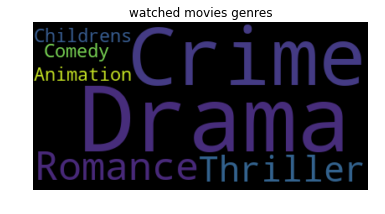

======= Preparing Dataset =======
======= Finshing Recommendations =======


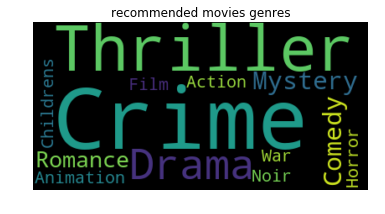

,movieId,title,genres
47,50,"Usual Suspects, The (1995)",Crime|Thriller
1192,1213,GoodFellas (1990),Crime|Drama
1070,1089,Reservoir Dogs (1992),Crime|Thriller
601,608,Fargo (1996),Crime|Drama|Thriller
586,593,"Silence of the Lambs, The (1991)",Drama|Thriller
1572,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
1676,1729,Jackie Brown (1997),Crime|Drama
3041,3114,Toy Story 2 (1999),Animation|Children's|Comedy
2195,2268,"Few Good Men, A (1992)",Crime|Drama
288,293,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller


In [8]:
#Titanic - Seven - pulb fiction - toy story
recommendMovies([{'id':1721,'rating':1},{'id':47,'rating':3},{'id':296,'rating':3},{'id':1,'rating':1}],20)